In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

class DubSeqViewer:
    
    
    def __init__(self, gscore_dir):
        self.__gscore_dir = gscore_dir
        self.__braseq_layout_df = pd.read_csv(os.path.join(gscore_dir,'barseq_layout.tsv'), sep='\t')
        self.__fscore_base_df = pd.read_csv(os.path.join(gscore_dir,'fscore_base.tsv'), sep='\t')
        self.__gscore_base_df = pd.read_csv(os.path.join(gscore_dir,'gscore_base.tsv'), sep='\t')
        
        self.__window_size = 14000
        self.__min_fscore = -5
        self.__max_fscore = 20
        self.__gene_y = 18
        self.__gene_x_offset = 200
        
        self.__itnum = None
        self.__fscores = None
        self.__gscores = None
        self.__cur_gene_index = 0
        self.__score_type = 'score_cnnls'
        self.__fr_covered_color = '#00FF00'
        self.__fr_non_covered_color = '#AAAAAA'
        self.__cur_gene_color = '#FF0000'
        self.__gene_color = '#000000'
        self.__gene_score_color = '#FF0000'        
        
    def set_score_type(self, score_type):
        self.__score_type = score_type
    
    def set_itnum(self, itnum):
        self.__itnum = itnum
        
        # Load fragment scores
        self.__fscores = pd.read_csv(os.path.join(self.__gscore_dir,'%s.fscore.tsv' %itnum), sep='\t')
        self.__fscores['pos_from'] = self.__fscore_base_df.pos_from
        self.__fscores['pos_to'] = self.__fscore_base_df.pos_to
    
        # Load gene scores
        self.__gscores = pd.read_csv(os.path.join(self.__gscore_dir,'%s.gscore.tsv' %itnum), sep='\t')
        self.__gscores['pos_from'] = self.__gscore_base_df.pos_from
        self.__gscores['pos_to'] = self.__gscore_base_df.pos_to
        self.__gscores['strand'] = self.__gscore_base_df.strand
        self.__gscores['name'] = self.__gscore_base_df['name']
        self.__gscores['locus_tag'] = self.__gscore_base_df.locus_tag
        self.__gscores['product'] = self.__gscore_base_df.product

        n = self.__gscore_base_df.shape[0]
        self.set_gene(index=self.__gscore_base_df.iloc[n//2]['gene_index'])        
        
    def set_gene(self, index=None, name=None, locus_tag=None):
        if index is not None:
            self.__cur_gene_index = index
        elif name is not None:
            genes = self.genes(name=name)
            if genes.shape[0] > 0:
                self.__cur_gene_index = genes.iloc[0]['gene_index']
        elif locus_tag is not None:
            genes = self.genes(locus_tag=locus_tag)
            if genes.shape[0] > 0:
                self.__cur_gene_index = genes.iloc[0]['gene_index']                                
    
    def __filter_range(self, d, pos_from, pos_to):
        if pos_from is not None:
            d = d[d.pos_from >= pos_from] 
        if pos_to is not None:
            d = d[d.pos_to <= pos_to]             
        return d
        
    def window(self):
        cur_gene = self.current_gene()
        gene_center = cur_gene.pos_from + (cur_gene.pos_to - cur_gene.pos_from)/2        
        window_from = gene_center - self.__window_size/2
        widnow_to = gene_center + self.__window_size/2     
        return (window_from, widnow_to)
        
    def set_window_size(self, window_size):
        self.__window_size = window_size        
        
    def zoom_in(self):
        self.__window_size /= 1.2
        
    def zoom_out(self):
        self.__window_size *= 1.2 
            
    def current_condition(self):
        d = self.__braseq_layout_df
        return d[d.itnum == self.__itnum].iloc[0]
    
    def current_gene(self):
        return self.__gscores.loc[self.__cur_gene_index]
    
    def next_gene(self):
        self.set_gene(index = self.__cur_gene_index + 1)

    def prev_gene(self):
        self.set_gene(index = self.__cur_gene_index - 1)
        
    
    def fscores(self, pos_from=None, pos_to=None):
        d = self.__fscores
        return self.__filter_range(d, pos_from, pos_to)
    
    def gscores(self, pos_from=None, pos_to=None):
        d = self.__gscores
        return self.__filter_range(d, pos_from, pos_to)
    
    def fragments(self, pos_from=None, pos_to=None):
        d = self.fscore_base
        return self.__filter_range(d, pos_from, pos_to)
        
    def genes(self, name=None, locus_tag=None, pos_from=None, pos_to=None):
        d = self.gscore_base
        if name is not None:
            d = d[d['name'].str.find(name) != -1] 
        if locus_tag is not None:
            d = d[d['locus_tag'].str.find(locus_tag) != -1] 
        return self.__filter_range(d, pos_from, pos_to)
    
    def conditions(self, name=None):
        d = self.braseq_layout
        if name is not None:
            d = d[d['name'].str.find(name) != -1]         
        return d

    @property
    def fscore_base(self):
        return self.__fscore_base_df
        
    @property
    def gscore_base(self):
        return self.__gscore_base_df
        
    @property
    def braseq_layout(self):
        return self.__braseq_layout_df
    
    @property
    def gscore_dir(self):
        return self.__gscore_dir

    def show_next_gene(self):
        self.next_gene()
        self.show()

    def show_prev_gene(self):
        self.prev_gene()
        self.show()
        
    def show_gene(self, name=None, locus_tag=None):
        self.set_gene(name=name, locus_tag=locus_tag)
        self.show()
        
    def show_zoom_in(self):
        self.zoom_in()
        self.show()
        
    def show_zoom_out(self):
        self.zoom_out()
        self.show()
        
    def show(self):
        cur_gene = self.current_gene()
        
        (window_from, widnow_to) = self.window()        
        genes = self.genes(pos_from=window_from, pos_to=widnow_to)
        fscores = self.fscores(pos_from=window_from, pos_to=widnow_to)
        
        fig = plt.figure(figsize=(15, 7))
        ax = fig.add_subplot(111)
        ax.set_title('DubSeq Viewer: %s' % self.current_condition()['name'], fontsize=15)
        ax.grid(True)

        # Do genes                
        for _, gene in genes.iterrows():
            color = self.__cur_gene_color  \
                if gene['gene_index'] == cur_gene['index'] \
                else self.__gene_color
                
            arrowstyle = '->' if gene.strand == '+' else '<-'
            ax.annotate(
                gene['name'],
                xy=(gene.pos_from + (gene.pos_to - gene.pos_from)/2, 18), 
                fontsize=10,
                xytext=(-10,20), textcoords='offset points', ha='left', va='top',
            )
            ax.annotate(
                '',
                xy=(gene.pos_to, 18), 
                xytext=(gene.pos_from, 18),
                fontsize=20,
                arrowprops=dict(arrowstyle = arrowstyle, color=color)
            )  

        # Do fragments            
        for _, fscore in fscores.iterrows():
            color = self.__fr_covered_color \
                if fscore.pos_from <= cur_gene.pos_from and fscore.pos_to >= cur_gene.pos_to \
                else self.__fr_non_covered_color
                
            ax.annotate(
                '',
                xy=(fscore.pos_to, fscore.score), 
                xytext=(fscore.pos_from, fscore.score),
                fontsize=20,
                arrowprops=dict(arrowstyle = '-', color=color)
            )  


        x_min = min( genes.pos_from.min(), fscores.pos_from.min()) - self.__gene_x_offset 
        x_max = max( genes.pos_to.max(),   fscores.pos_to.max()) + self.__gene_x_offset 
        y_min =  min( self.__min_fscore, fscores.score.min() ) 
        y_max =  max( self.__max_fscore, fscores.score.max() ) 

        # Do gene score
        gscore = cur_gene[self.__score_type]
        
        ax.annotate(
            '%s = %.2f'% (cur_gene['name'], gscore) ,
            xy=(x_max - self.__gene_x_offset, gscore), 
            fontsize=10,
            xytext=(-70,20), textcoords='offset points', ha='left', va='top', color = self.__gene_score_color 
        )        
        ax.annotate(
            '',
            xy=(x_min + self.__gene_x_offset, gscore), 
            xytext=(x_max - self.__gene_x_offset,gscore ),
            fontsize=20,
            arrowprops=dict(arrowstyle = '-', color = self.__gene_score_color)
        )              
        
        
        ax.axis([ x_min, x_max, y_min, y_max])
        plt.ylabel('fitness score')
        plt.show()         
    
    


# DubSeq viewer demo

### Create an instance of the browser and provide a "gscore" folder

In [2]:
dbv = DubSeqViewer('/Users/psnovichkov/work/dubseq/vivek_mutalik/dubseq/gscore/FEBA_133') 

### Check conditions

In [3]:
dbv.conditions().head(10)

,itnum,type,name
0,IT001,stress,Nickel (II) chloride hexahydrate 1.2mM
1,IT002,stress,Cobalt chloride hexahydrate 0.75mM
2,IT003,stress,Cobalt chloride hexahydrate 1mM
3,IT004,stress,copper (II) chloride dihydrate 2mM
4,IT005,stress,copper (II) chloride dihydrate 5mM
5,IT006,stress,sodium fluoride 50mM
6,IT007,stress,sodium fluoride 100mM
7,IT008,stress,sodium fluoride 200mM
8,IT009,stress,Paraquat dichloride 0.064mg/ml
9,IT010,LB,LB


In [4]:
dbv.conditions('hexa')

,itnum,type,name
0,IT001,stress,Nickel (II) chloride hexahydrate 1.2mM
1,IT002,stress,Cobalt chloride hexahydrate 0.75mM
2,IT003,stress,Cobalt chloride hexahydrate 1mM


In [5]:
dbv.conditions('Nickel')

,itnum,type,name
0,IT001,stress,Nickel (II) chloride hexahydrate 1.2mM


### Let us play with Nickel: set the default itnum = IT001

In [6]:
dbv.set_itnum('IT001')

### Show the plot for rcnA gene

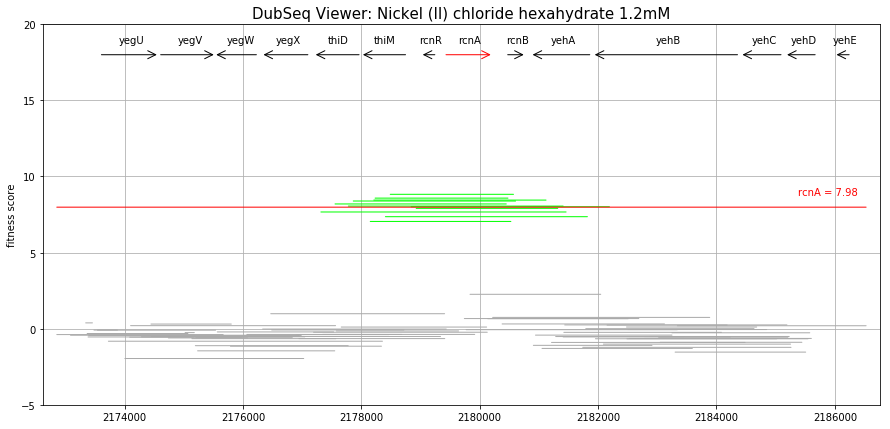

In [7]:
dbv.show_gene(name='rcnA')

### Show next/prev gene

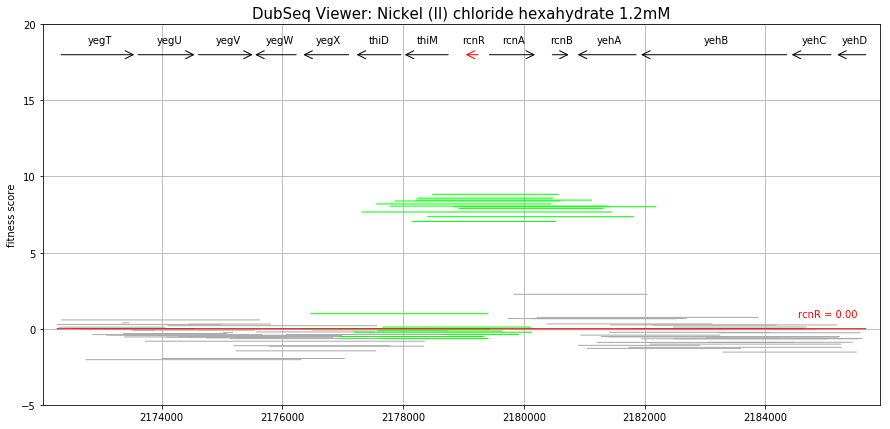

In [8]:
# dbv.show_next_gene()
dbv.show_prev_gene()

### Zoom in/out

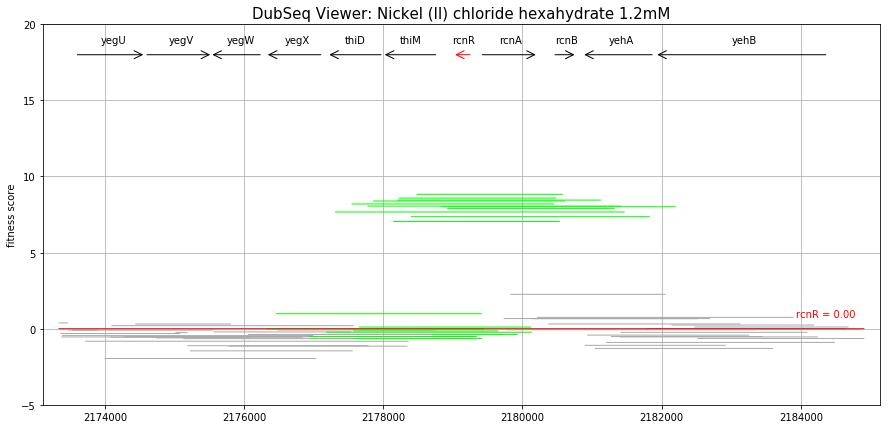

In [9]:
# dbv.show_zoom_out()
dbv.show_zoom_in()

### Change the condition

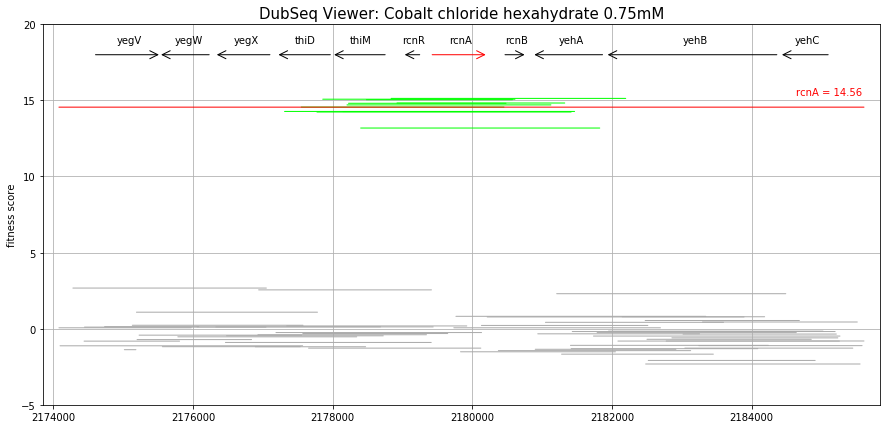

In [10]:
dbv.set_itnum('IT002')
dbv.show_gene('rcnA')

### Check current gene/condition

In [11]:
dbv.current_gene()

index                                                       2169
gene_name                                                   rcnA
locus_tag                                           BW25113_2106
score_mean                                               14.5558
score_cnnls                                              14.5558
score_ridge                                              14.9185
score_enet                                               14.5422
pos_from                                                 2179396
pos_to                                                   2180220
strand                                                         +
name                                                        rcnA
product        <bound method DataFrame.prod of       gene_ind...
Name: 2169, dtype: object

In [12]:
dbv.current_condition()

itnum                                 IT002
type                                 stress
name     Cobalt chloride hexahydrate 0.75mM
Name: 1, dtype: object

### Get gscores/fscores for the cuurent condition

In [13]:
gscores = dbv.gscores()

In [14]:
gscores.head()

,index,gene_name,locus_tag,score_mean,score_cnnls,score_ridge,score_enet,pos_from,pos_to,strand,name,product
0,0,thrL,BW25113_0001,-1.239655,-1.239655,0.000000,0.000000,190,255,+,thrL,<bound method DataFrame.prod of gene_ind...
1,1,thrA,BW25113_0002,-1.239655,0.000000,0.000000,0.000000,337,2799,+,thrA,<bound method DataFrame.prod of gene_ind...
2,2,thrB,BW25113_0003,0.192964,0.192964,0.573215,0.558450,2801,3733,+,thrB,<bound method DataFrame.prod of gene_ind...
3,3,thrC,BW25113_0004,-0.246036,0.000000,0.095408,0.081507,3734,5020,+,thrC,<bound method DataFrame.prod of gene_ind...
4,4,yaaX,BW25113_0005,-0.404016,-0.404016,-0.420417,-0.408613,5234,5530,+,yaaX,<bound method DataFrame.prod of gene_ind...


In [15]:
fscores = dbv.fscores()

In [16]:
fscores.head()

,barcode,score,stress_read_count,t0_total_read_count,pos_from,pos_to
0,TTCATTCCTGAGGAACTGAT,0.298658,0,49,2798632,2801095
1,GATGTTGCAGCCAGACCTGA,0.270089,0,50,711570,713968
2,GGGGTGCCAGTCGTTGTGAT,0.733061,0,36,1700528,1703659
3,AGAAACACAGCGTTTAGGAC,1.335184,7,194,1921971,1923952
4,TACGAGTGTGTCAGGGTGTG,-0.494891,5,519,1571067,1573356


### Top gscore/fscores

In [17]:
gscores.sort_values('score_cnnls', ascending=False).head()

,index,gene_name,locus_tag,score_mean,score_cnnls,score_ridge,score_enet,pos_from,pos_to,strand,name,product
2169,2169,rcnA,BW25113_2106,14.555756,14.555756,14.918510,14.542193,2179396,2180220,+,rcnA,<bound method DataFrame.prod of gene_ind...
2574,2574,yfgG,BW25113_2504,13.510174,13.175929,13.196723,13.125315,2622649,2622840,+,yfgG,<bound method DataFrame.prod of gene_ind...
1771,1771,yniD,BW25113_4535,10.089387,10.052295,10.215380,10.090839,1799422,1799529,+,yniD,<bound method DataFrame.prod of gene_ind...
4022,4022,hslU,BW25113_3931,7.787549,6.741273,6.446996,6.325280,4110344,4111675,-,hslU,<bound method DataFrame.prod of gene_ind...
3959,3959,yihI,BW25113_3866,4.417399,4.331748,6.728005,6.501140,4044707,4045216,+,yihI,<bound method DataFrame.prod of gene_ind...


In [18]:
fscores.sort_values('score', ascending=False).head()

,barcode,score,stress_read_count,t0_total_read_count,pos_from,pos_to
7682,AGCGATCACATTAGGCTCGG,15.131324,65361,111,2178808,2182225
10685,TCTGTATGGAATGTTGAGTT,15.078128,82681,146,2177829,2180639
20002,TGATTTGAGTAAAGGATTCG,15.044406,85716,155,2178454,2180604
9052,GCGTTATGGGAGACCGCCCT,14.827056,422050,892,2178892,2181352
937,CGTGCAATAGAGCGGCGAAG,14.810062,96686,206,2178198,2180511


### Find genes/fragments and their scores in a give region

In [19]:
# neighbours of rcnA gene
rcnA = dbv.genes(name='rcnA').iloc[0]
region_from = rcnA.pos_from - 3000
region_to   = rcnA.pos_from + 3000
print( 'region_from=%s; region_to=%s' %(region_from, region_to) )

region_from=2176396; region_to=2182396


In [20]:
region_gscores = dbv.gscores(pos_from = region_from, pos_to = region_to)
print('Number of genes: %s' % region_gscores.shape[0])
region_gscores


Number of genes: 6


,index,gene_name,locus_tag,score_mean,score_cnnls,score_ridge,score_enet,pos_from,pos_to,strand,name,product
2166,2166,thiD,BW25113_2103,-0.115767,-0.037070,0.276975,0.159457,2177195,2177995,-,thiD,<bound method DataFrame.prod of gene_ind...
2167,2167,thiM,BW25113_2104,4.820718,0.000000,0.042335,-0.077643,2177992,2178780,-,thiM,<bound method DataFrame.prod of gene_ind...
2168,2168,rcnR,BW25113_2105,8.411247,0.000000,0.439937,0.633597,2179003,2179275,-,rcnR,<bound method DataFrame.prod of gene_ind...
2169,2169,rcnA,BW25113_2106,14.555756,14.555756,14.918510,14.542193,2179396,2180220,+,rcnA,<bound method DataFrame.prod of gene_ind...
2170,2170,rcnB,BW25113_2107,7.104731,0.000000,-0.467137,-0.270319,2180439,2180777,+,rcnB,<bound method DataFrame.prod of gene_ind...
2171,2171,yehA,BW25113_2108,2.004786,0.000000,0.938492,0.679846,2180859,2181893,-,yehA,<bound method DataFrame.prod of gene_ind...


In [21]:
region_fscores = dbv.fscores(pos_from = region_from, pos_to = region_to)
print('Number of fragmetns: %s' % region_fscores.shape[0])
region_fscores

Number of fragmetns: 21


,barcode,score,stress_read_count,t0_total_read_count,pos_from,pos_to
937,CGTGCAATAGAGCGGCGAAG,14.810062,96686,206,2178198,2180511
1279,TACGTTAAAGCTAGTACTCG,14.235664,54893,174,2177746,2181443
3022,ACAATACGCTCCGGGGTATT,2.550197,1,20,2176911,2179443
3657,GGAGGCGGGTAAGGCGGGTG,-0.902976,0,114,2176435,2179440
4348,AATATGATGACCACACCTTT,0.180963,3,216,2177312,2179949
5320,AACTGGGAAACCCCCGAGCC,14.265767,205948,642,2178116,2180560
6526,CTCGGTTTTTTGCAATACCC,14.703189,95421,219,2178176,2181154
7487,TTCCGTCGCGGCATGGGTAC,-1.186769,1,279,2176862,2178500
7682,AGCGATCACATTAGGCTCGG,15.131324,65361,111,2178808,2182225
9052,GCGTTATGGGAGACCGCCCT,14.827056,422050,892,2178892,2181352
